In [1]:
# Loading packages

# Visualization and Analysis
import numpy as np
import pandas as pd
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt
import seaborn
import datetime as dt
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# SQLAlchemy and ORM
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect, and_

# Building Engine, Automapping Base, Staring Session
engine = create_engine("sqlite:///Resources/hawaii.sqlite")
Base = automap_base()
Base.prepare(engine, reflect=True)
session = Session(engine)
inspector = inspect(engine)

# Viewing classes from automap
# Base.classes.keys()

In [2]:
# Defining references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

# Printing table columns for reference
f"measurement table columns"
measurement_columns = inspector.get_columns('measurement')
for m_c in measurement_columns:
    print(m_c['name'], m_c["type"])
f"---"
f"station table columns"
station_columns = inspector.get_columns('station')
for s_c in station_columns:
    print(s_c['name'], s_c["type"])

'measurement table columns'

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


'---'

'station table columns'

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [3]:
# Previewing table items
engine.execute('SELECT * FROM measurement LIMIT 10').fetchall()
engine.execute('SELECT * FROM station LIMIT 10').fetchall()

[(1, 'USC00519397', '2010-01-01', 0.08, 65.0),
 (2, 'USC00519397', '2010-01-02', 0.0, 63.0),
 (3, 'USC00519397', '2010-01-03', 0.0, 74.0),
 (4, 'USC00519397', '2010-01-04', 0.0, 76.0),
 (5, 'USC00519397', '2010-01-06', None, 73.0),
 (6, 'USC00519397', '2010-01-07', 0.06, 70.0),
 (7, 'USC00519397', '2010-01-08', 0.0, 64.0),
 (8, 'USC00519397', '2010-01-09', 0.0, 68.0),
 (9, 'USC00519397', '2010-01-10', 0.0, 73.0),
 (10, 'USC00519397', '2010-01-11', 0.01, 64.0)]

[(1, 'USC00519397', 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0),
 (2, 'USC00513117', 'KANEOHE 838.1, HI US', 21.4234, -157.8015, 14.6),
 (3, 'USC00514830', 'KUALOA RANCH HEADQUARTERS 886.9, HI US', 21.5213, -157.8374, 7.0),
 (4, 'USC00517948', 'PEARL CITY, HI US', 21.3934, -157.9751, 11.9),
 (5, 'USC00518838', 'UPPER WAHIAWA 874.3, HI US', 21.4992, -158.0111, 306.6),
 (6, 'USC00519523', 'WAIMANALO EXPERIMENTAL FARM, HI US', 21.33556, -157.71139, 19.5),
 (7, 'USC00519281', 'WAIHEE 837.5, HI US', 21.45167, -157.84888999999998, 32.9),
 (8, 'USC00511918', 'HONOLULU OBSERVATORY 702.2, HI US', 21.3152, -157.9992, 0.9),
 (9, 'USC00516128', 'MANOA LYON ARBO 785.2, HI US', 21.3331, -157.8025, 152.4)]

# Exploratory Climate Analysis

In [64]:
# Notes: 
# - precipitation abbreviated as prcp and temperature 
# abbreviated as tobs like in measurement table
# -  .label() is the same as SQL select as aliasing

# Figuring out the latest date and the year prior in the dataset
latest_date_query = str(session.query(Measurement.date).order_by(Measurement.date.desc()).first())
latest_date = latest_date_query[2:12]
f"The latest date in the dataset: {latest_date}"

year_before_latest_date_calc = str(int(latest_date[0:4]) - 1)
year_before_latest_date = year_before_latest_date_calc + latest_date[4:]
f"The year before the latest date in the dataset: {year_before_latest_date}"

# Retrieving last 12 months of prcp data
prcp_raw_points = session.query(Measurement.date.label('Date'),
                    Measurement.station.label('Station_ID'),
                    Measurement.prcp.label('Precipitation levels')).\
                    filter(Measurement.date.between(year_before_latest_date,latest_date)).\
                    order_by(Measurement.date)

prcp_df = pd.read_sql(prcp_raw_points.statement, prcp_raw_points.session.bind)

# Legacy code: Alternate way of making a dataframe using list comprehensions
# to unpack the output of tuples
# dates = [prcp_raw_point[0] for prcp_raw_point in prcp_raw_points]
# station_names = [prcp_raw_point[1] for prcp_raw_point in prcp_raw_points]
# prcp_points = [prcp_raw_point[2] for prcp_raw_point in prcp_raw_points]
# prcp_df = pd.DataFrame(
#     {'Date': dates,
#      'Station': station_names,
#      'Precipitation levels': prcp_points})

# Setting Date as the index
prcp_df.set_index('Date', inplace=True)

# Sorting by Date
prcp_df.sort_values(by='Date', ascending=True).head(10)
prcp_df.tail(10)

'The latest date in the dataset: 2017-08-23'

'The year before the latest date in the dataset: 2016-08-23'

,Station_ID,Precipitation levels
Date,,
2016-08-23,USC00519397,0.00
2016-08-23,USC00513117,0.15
2016-08-23,USC00514830,0.05
2016-08-23,USC00517948,NaN
2016-08-23,USC00519523,0.02
2016-08-23,USC00519281,1.79
2016-08-23,USC00516128,0.70
2016-08-24,USC00516128,1.45
2016-08-24,USC00519281,2.15


,Station_ID,Precipitation levels
Date,,
2017-08-21,USC00514830,0.02
2017-08-21,USC00519523,NaN
2017-08-21,USC00516128,0.56
2017-08-22,USC00519397,0.00
2017-08-22,USC00519523,0.00
2017-08-22,USC00516128,0.50
2017-08-23,USC00519397,0.00
2017-08-23,USC00514830,0.00
2017-08-23,USC00519523,0.08


In [5]:
# prcp_df
# (do a groupby month by extracting the string year-month

<Figure size 1224x360 with 0 Axes>

Text(0, 0.5, 'Precipitation (inches)')

Text(0.5, 0, 'Date')

Text(0.5, 1.0, 'Precipitation Levels 08/23/2016 - 08/23/2017')

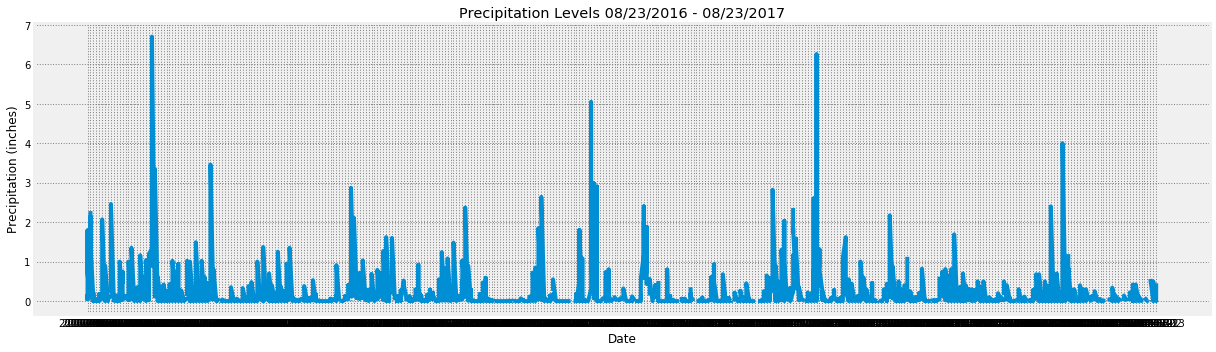

In [70]:
# Plotting figure of prcp_df
plt.figure(figsize=(17,5))
plt.plot(prcp_df.index, prcp_df['Precipitation levels'])
plt.ylabel("Precipitation (inches)")
plt.xlabel("Date")
plt.title("Precipitation Levels 08/23/2016 - 08/23/2017")
plt.tight_layout()

plt.show()

In [7]:
# prcp_df summary statistics
prcp_df.describe()

# Number of stations in dataset
HI_stations_count = session.query(Station).group_by(Station.station).count()
f"There are {HI_stations_count} weather stations in this dataset."

,Precipitation levels
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


'There are 9 weather stations in this dataset.'

In [8]:
# Listing stations in descending order of activity 
# in the whole dataset (via tobs count)
# Putting it into a dataframe for readability
StationActivity = session.query(Station.station.label('Station_ID'), 
                                Station.name.label('Station_Name'),
                                func.count(Measurement.tobs).label('Activity_Count')).\
                                filter(Station.station == Measurement.station).\
                                group_by(Measurement.station).\
                                order_by(func.count(Measurement.tobs).desc())
StationActivity_df = pd.read_sql(StationActivity.statement, StationActivity.session.bind)
StationActivity_df

f"The station with the most activity is Station ID: {StationActivity_df.at[0,'Station_ID']},"
f"at {StationActivity_df.at[0,'Station_Name']} with {StationActivity_df.at[0,'Activity_Count']} datapoints in the dataset."

,Station_ID,Station_Name,Activity_Count
0,USC00519281,"WAIHEE 837.5, HI US",2772
1,USC00519397,"WAIKIKI 717.2, HI US",2724
2,USC00513117,"KANEOHE 838.1, HI US",2709
3,USC00519523,"WAIMANALO EXPERIMENTAL FARM, HI US",2669
4,USC00516128,"MANOA LYON ARBO 785.2, HI US",2612
5,USC00514830,"KUALOA RANCH HEADQUARTERS 886.9, HI US",2202
6,USC00511918,"HONOLULU OBSERVATORY 702.2, HI US",1979
7,USC00517948,"PEARL CITY, HI US",1372
8,USC00518838,"UPPER WAHIAWA 874.3, HI US",511


'The station with the most activity is Station ID: USC00519281,'

'at WAIHEE 837.5, HI US with 2772 datapoints in the dataset.'

In [9]:
# Calculating the lowest temperature recorded, highest temperature recorded, 
# and average temperature from WAIHEE 837.5 in the whole dataset

Lowest_tobs_calc = session.query(func.min(Measurement.tobs)).\
            filter(Station.station == 'USC00519281').all()
Lowest_tobs_format = str(Lowest_tobs_calc[0])
Lowest_tobs = Lowest_tobs_format[1:3]
f"Lowest temperature recorded at Waihee: {Lowest_tobs} degrees"

Highest_tobs_calc = session.query(func.max(Measurement.tobs)).\
            filter(Station.station == 'USC00519281').all()
Highest_tobs_format = str(Highest_tobs_calc[0])
Highest_tobs = Highest_tobs_format[1:3]
f"Lowest temperature recorded at Waihee: {Highest_tobs} degrees"

Avg_tobs_calc = session.query(func.avg(Measurement.tobs)).\
            filter(Station.station == 'USC00519281').all()
Avg_tobs_format = str(Avg_tobs_calc[0])
Avg_tobs = Avg_tobs_format[1:3]
f"Average temperature recorded at Waihee: {Avg_tobs} degrees"

'Lowest temperature recorded at Waihee: 53 degrees'

'Lowest temperature recorded at Waihee: 87 degrees'

'Average temperature recorded at Waihee: 73 degrees'

In [10]:
# Retrieving last 12 months of tobs data from all stations
tobs_raw_points = session.query(Measurement.date.label('Date'),
                    Measurement.station.label('Station_ID'),
                    Measurement.tobs.label('Observed Temp')).\
                    filter(Measurement.date.between(year_before_latest_date,latest_date)).\
                    order_by(Measurement.date)

tobs_df = pd.read_sql(tobs_raw_points.statement, tobs_raw_points.session.bind)

# Setting Date as the index
tobs_df.set_index('Date', inplace=True)

# Sorting by Date
tobs_df.sort_values(by='Date', ascending=True).head(10)
# tobs_df.tail(10)

,Station_ID,Observed Temp
Date,,
2016-08-23,USC00519397,81.0
2016-08-23,USC00513117,76.0
2016-08-23,USC00514830,80.0
2016-08-23,USC00517948,80.0
2016-08-23,USC00519523,80.0
2016-08-23,USC00519281,77.0
2016-08-23,USC00516128,74.0
2016-08-24,USC00516128,74.0
2016-08-24,USC00519281,77.0


In [11]:
# Retrieving last 12 months of tobs data from Waihee
Waihee_raw_points = session.query(Measurement.date.label('Date'),
                    Measurement.tobs.label('Observed Temp')).\
                    filter(Measurement.date.between(year_before_latest_date,latest_date)).\
                    filter(Measurement.station == 'USC00519281').\
                    order_by(Measurement.date)

# Making a dataframe and finding its shape to confirm there
# is around a year's worth of data
Waihee_df = pd.read_sql(Waihee_raw_points.statement, Waihee_raw_points.session.bind)
Waihee_df.shape 
Waihee_df.head(5)

(352, 2)

,Date,Observed Temp
0,2016-08-23,77.0
1,2016-08-24,77.0
2,2016-08-25,80.0
3,2016-08-26,80.0
4,2016-08-27,75.0


(array([ 5.,  7.,  7., 12., 27., 41., 40., 57., 66., 53., 29.,  8.]),
 array([59., 61., 63., 65., 67., 69., 71., 73., 75., 77., 79., 81., 83.]),
 <a list of 12 Patch objects>)

Text(0, 0.5, 'Frequency')

Text(0.5, 0, 'Observed Temperature')

Text(0.5, 1.0, 'Observed Temperatures at Waihee 08/23/2016 - 08/23/2017')

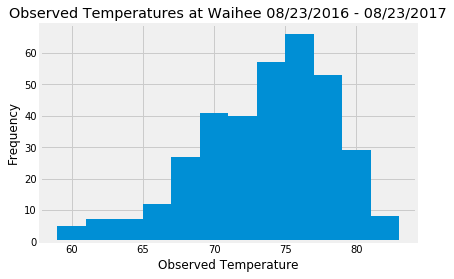

In [12]:
# Plotting a histogram for the last 12 months of tobs data from WAIHEE 837.5
tobs = [x[1] for x in Waihee_raw_points]
plt.hist(tobs, bins=12)
plt.ylabel("Frequency")
plt.xlabel("Observed Temperature")
plt.title("Observed Temperatures at Waihee 08/23/2016 - 08/23/2017")
#plt.savefig()
plt.show()

In [13]:
# Using provided `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.

def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
    Returns:
        TMIN, TAVE, and TMAX
    """
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# Using the date range 2017-03-05 to 2017-03-17
trip = calc_temps('2017-03-05', '2017-03-17')[0]
f"For the duration of 3/5/17 to 3/17/17:"
f"Min temp: {trip[0]}"
f"Max temp: {trip[2]}"
f"Average temp: {trip[1]}"

'For the duration of 3/5/17 to 3/17/17:'

'Min temp: 62.0'

'Max temp: 82.0'

'Average temp: 70.7375'

<Figure size 144x432 with 0 Axes>

Text(0.5, 1.0, 'Trip Average Temp')

Text(0, 0.5, 'Temperature (F)')

<BarContainer object of 1 artists>

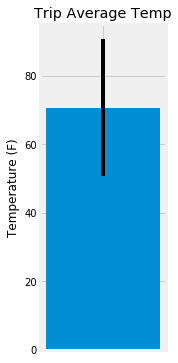

In [14]:
# Plotting a bar chart for the average temp calculated above
# with the "peak-to-peak" (tmax-tmin) value as an error barr

plt.figure(figsize=(2,6))
plt.title("Trip Average Temp")
plt.ylabel("Temperature (F)")
plt.bar(1, trip[1], yerr = (trip[2] - trip[0]), tick_label = "")
# plt.savefig("Outputs/Temperature Analysis.png")
plt.show()

In [15]:
# Calculating rainfall per weather station for the dates used above
# Sorted in descending order

AllStationRainfall_During_Trip = session.query(Station.station.label('Station_ID'), 
                                Station.name.label('Station_Name'),
                                Station.latitude.label('Latitude'),
                                Station.longitude.label('Longitude'),
                                Station.elevation.label('Elevation'),
                                func.sum(Measurement.prcp).label('Precipitation Total')).\
                                filter(Station.station == Measurement.station).\
                                filter(Measurement.date.between('2017-03-05', '2017-03-17')).\
                                group_by(Measurement.station).\
                                order_by(func.sum(Measurement.prcp).desc())
AllStationRainfall_During_Trip_df = pd.read_sql(AllStationRainfall_During_Trip.statement, 
                                                AllStationRainfall_During_Trip.session.bind)
AllStationRainfall_During_Trip_df

,Station_ID,Station_Name,Latitude,Longitude,Elevation,Precipitation Total
0,USC00513117,"KANEOHE 838.1, HI US",21.42340,-157.80150,14.6,1.76
1,USC00519281,"WAIHEE 837.5, HI US",21.45167,-157.84889,32.9,1.31
2,USC00514830,"KUALOA RANCH HEADQUARTERS 886.9, HI US",21.52130,-157.83740,7.0,0.69
3,USC00516128,"MANOA LYON ARBO 785.2, HI US",21.33310,-157.80250,152.4,0.36
4,USC00519397,"WAIKIKI 717.2, HI US",21.27160,-157.81680,3.0,0.35
5,USC00519523,"WAIMANALO EXPERIMENTAL FARM, HI US",21.33556,-157.71139,19.5,0.35
6,USC00517948,"PEARL CITY, HI US",21.39340,-157.97510,11.9,0.06


In [29]:
# Using provided query to calculate the daily normals for the date range
# (daily normals = averages for tmin, tmax, and tavg for all historic 
# data matching a specific month and day)
def daily_normals(date):
    """Daily Normals. 
    Args:
        date (str): A date string in the format '%m-%d'       
    Returns:
        A list of tuples containing the daily normals, tmin, tmax, and tavg   
    """   
    sel = [func.min(Measurement.tobs),func.max(Measurement.tobs),func.avg(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date)

# Using the date range 2017-03-05 to 2017-03-17
# Making a list of dates, based on
# https://stackoverflow.com/a/24637447
trip_dates = []
trip_daily_normals = []

start = dt.datetime.strptime("03-05", "%m-%d")
end = dt.datetime.strptime("03-17", "%m-%d")
date_generated = [start + dt.timedelta(days=x) for x in range(0, (end-start).days + 1)]

for date in date_generated:
    trip_dates.append(date.strftime("%m-%d"))

# Making a list of daily normals from the dates generated above
for date in trip_dates:
    trip_daily_normals.append(daily_normals(date)[0])

# Unpacking the tuples from the above list
trip_tmins = [trip_daily_normal[0] for trip_daily_normal in trip_daily_normals]
trip_tmaxs = [trip_daily_normal[1] for trip_daily_normal in trip_daily_normals]
trip_tavgs = [trip_daily_normal[2] for trip_daily_normal in trip_daily_normals]

# Making a dataframe with these results, making trip_dates the index
dailynorms_df = pd.DataFrame(
    {'Trip Dates': trip_dates,
     'Min Temp': trip_tmins,
     'Max Temp': trip_tmaxs,
     'Avg Temp': trip_tavgs})

# Setting Date as the index
dailynorms_df.set_index('Trip Dates', inplace=True)

# Sorting by Date
dailynorms_df.sort_values(by='Trip Dates', ascending=True)

,Min Temp,Max Temp,Avg Temp
Trip Dates,,,
03-05,60.0,76.0,67.890909
03-06,60.0,76.0,69.203390
03-07,60.0,78.0,69.172414
03-08,59.0,78.0,68.724138
03-09,57.0,75.0,68.561404
03-10,57.0,75.0,69.122807
03-11,60.0,82.0,69.892857
03-12,62.0,80.0,69.888889
03-13,56.0,77.0,69.296296


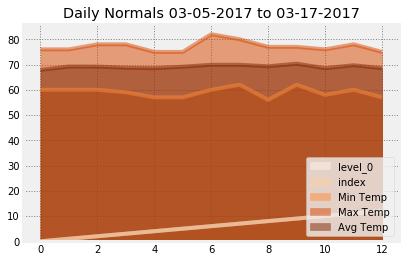

In [61]:
# Plotting daily normals as an area plot with `stacked=False`
# Reference: https://stackoverflow.com/questions/34421434/pandas-dataframe-area-plot-stacked-false-not-working
dailynorms_df.plot(kind='area', stacked=False, alpha=0.5, colormap='Oranges', grid=True, 
                   title='Daily Normals 03-05-2017 to 03-17-2017')
plt.legend(loc='lower right')
plt.rc('grid', linestyle=":", linewidth=1, color='gray')
plt.show()


# get the xaxis dates 

# trying to get this to work: 
# https://stackoverflow.com/questions/50805666/showing-index-as-xticks-for-pandas-plot
    

## See Step 2 for Flask API.py [hyperlink here when done]
